In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil

# copy dataset from google drive to local storage
drive_data_path = '/content/drive/MyDrive/dynamic_res/imagenette2'
local_data_path = '/content/imagenette2'

if not os.path.exists(local_data_path):
    shutil.copytree(drive_data_path, local_data_path)
else:
    print(f'dataset already exists at {local_data_path}')

data_path = local_data_path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
dataset already exists at /content/imagenette2


In [3]:
import numpy as np

import argparse
import time
import csv
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import sys

import matplotlib.pyplot as plt

# Identify Model Accuracy on Each Individual Class

In [5]:
def parse_args():
    argv = [arg for arg in sys.argv if not arg.startswith('-f')]

    parser = argparse.ArgumentParser()

    parser.add_argument('data')
    parser.add_argument('--arch', default='resnet18')
    parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--batch-size', default=128, type=int)
    parser.add_argument('--lr', default=0.1, type=float)
    parser.add_argument('--momentum', default=0.9, type=float)
    parser.add_argument('--weight-decay', default=1e-4, type=float)
    parser.add_argument('--workers', default=2, type=int)
    parser.add_argument('--print-freq', default=10, type=int)
    parser.add_argument('--resolution', default=224, type=int)

    return parser.parse_args(argv[1:])

class RobustImageFolder(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        try:
            return self.base_dataset[idx]
        except Exception as e:
            print(f'skipping corrupted image at index {idx}: {e}')
            return self.__getitem__((idx + 1) % len(self.base_dataset))

def validate(val_loader, model, device):
    outputs = torch.tensor([])
    model.eval()

    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            print(i)
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            outputs = outputs.to(device, non_blocking=True)

            output = torch.argmax(model(images), dim=1)
            outputs = torch.cat((outputs, output), dim=0)

    outputs = outputs.to('cpu', non_blocking=True)

    return outputs

def main():
    args = parse_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load trained model
    model = models.__dict__[args.arch](num_classes=10)
    params = torch.load('/content/drive/MyDrive/dynamic_res/model_inverted.pth', map_location=torch.device(device))
    model.load_state_dict(params)
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    # load Imagenette validation dataset
    valdir = os.path.join(args.data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    base_val_dataset = datasets.ImageFolder(valdir, transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize]))
    val_dataset = RobustImageFolder(base_val_dataset)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)

    # identify class labels
    class_names = ['tench', 'english springer', 'cassette player', 'chainsaw', 'church', 'french horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
    targets = torch.tensor(base_val_dataset.targets)
    target_freq = torch.bincount(targets)
    print("Total Number of Samples Per Class:")
    for i in range(len(class_names)):
        print(f"\t{class_names[i]}: {target_freq[i]}")

    # evaluate model
    outputs = validate(val_loader, model, device)

    cm = confusion_matrix(targets, outputs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)

    plt.title("Inverted Confusion Matrix")
    plt.show()

    # save target and output values for further testing
    np.savez("eval_inverted.npz", target=targets, output=outputs)

Total Number of Samples Per Class:
	tench: 387
	english springer: 395
	cassette player: 357
	chainsaw: 386
	church: 409
	french horn: 394
	garbage truck: 389
	gas pump: 419
	golf ball: 399
	parachute: 390
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


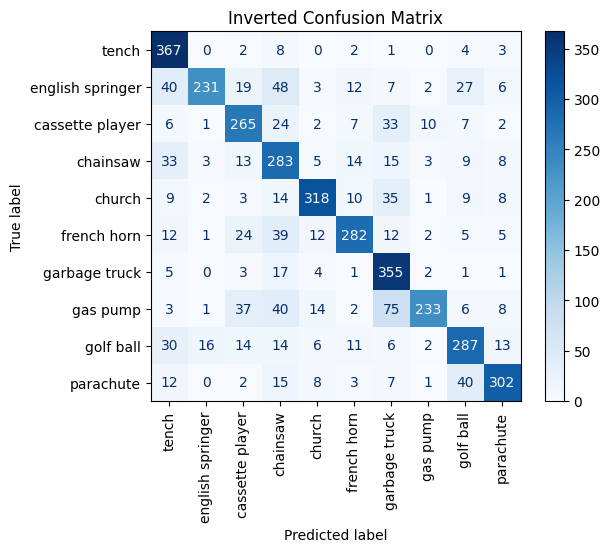

In [6]:
sys.argv = ['train.py', data_path, '--arch', 'resnet18', '--epochs', '30', '--batch-size', '128', '--workers', '2', '--resolution', '224']
main()

# Identify Performance on Individual Image Resolutions

In [8]:
def parse_args():
    argv = [arg for arg in sys.argv if not arg.startswith('-f')]

    parser = argparse.ArgumentParser()

    parser.add_argument('data')
    parser.add_argument('--arch', default='resnet18')
    parser.add_argument('--epochs', default=30, type=int)
    parser.add_argument('--batch-size', default=128, type=int)
    parser.add_argument('--lr', default=0.1, type=float)
    parser.add_argument('--momentum', default=0.9, type=float)
    parser.add_argument('--weight-decay', default=1e-4, type=float)
    parser.add_argument('--workers', default=2, type=int)
    parser.add_argument('--print-freq', default=10, type=int)
    parser.add_argument('--resolution', default=224, type=int)

    return parser.parse_args(argv[1:])

class RobustImageFolder(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        try:
            return self.base_dataset[idx]
        except Exception as e:
            print(f'skipping corrupted image at index {idx}: {e}')
            return self.__getitem__((idx + 1) % len(self.base_dataset))

def validate(val_loader, model, device):
    outputs = torch.tensor([])
    model.eval()

    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            print(i)
            images = images.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            outputs = outputs.to(device, non_blocking=True)

            output = torch.argmax(model(images), dim=1)
            outputs = torch.cat((outputs, output), dim=0)

    outputs = outputs.to('cpu', non_blocking=True)

    return outputs

def main():
    args = parse_args()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # load trained model
    model = models.__dict__[args.arch](num_classes=10)
    params = torch.load('/content/drive/MyDrive/dynamic_res/model_baseline.pth', map_location=torch.device(device))
    model.load_state_dict(params)
    model = model.to(device)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)

    # load Imagenette validation dataset
    valdir = os.path.join(args.data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    base_val_dataset = datasets.ImageFolder(valdir, transforms.Compose([transforms.Resize(256), transforms.RandomResizedCrop(args.resolution), transforms.ToTensor(), normalize]))
    val_dataset = RobustImageFolder(base_val_dataset)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)

    # identify class labels
    class_names = ['tench', 'english springer', 'cassette player', 'chainsaw', 'church', 'french horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']
    targets = torch.tensor(base_val_dataset.targets)
    target_freq = torch.bincount(targets)
    print("Total Number of Samples Per Class:")
    for i in range(len(class_names)):
        print(f"\t{class_names[i]}: {target_freq[i]}")

    # evaluate model
    outputs = validate(val_loader, model, device)

    cm = confusion_matrix(targets, outputs)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)

    plt.title("Baseline Confusion Matrix")
    plt.show()

    # save target and output values for further testing
    np.savez("eval_baseline_224x224.npz", target=targets, output=outputs)

Total Number of Samples Per Class:
	tench: 387
	english springer: 395
	cassette player: 357
	chainsaw: 386
	church: 409
	french horn: 394
	garbage truck: 389
	gas pump: 419
	golf ball: 399
	parachute: 390
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


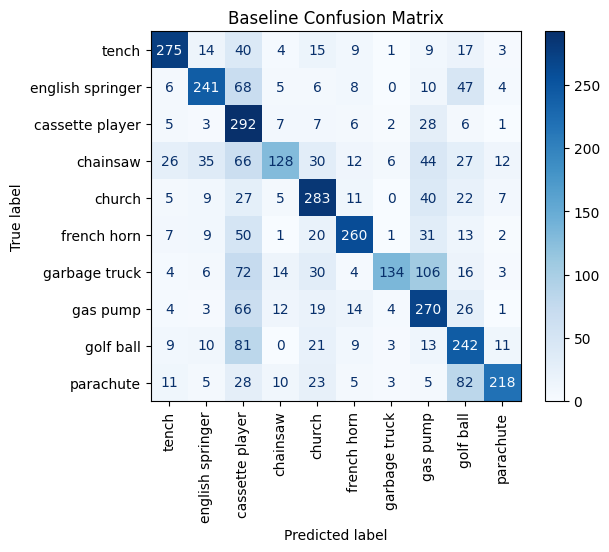

In [9]:
sys.argv = ['train.py', data_path, '--arch', 'resnet18', '--epochs', '30', '--batch-size', '128', '--workers', '2', '--resolution', '224']
main()